In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

    Author(s): Daniel Tweneboah Anyimadu, Taofik Ahmed Suleiman

# **CADx PROJECT: SKIN LESION CLASSIFICATION CHALLENGE USING DEEP LEARNING APPROACH**

- A deep learning (DL) approach is employed to address both two-class and three-class problems, improving classification accuracy despite huge class imbalances and lesion variations.

- **NB:** This code is for the two (2) class problem: nevus, others.

# IMPORT LIBRARIES (MODULES)

In [1]:
# Libraries for exploratory data analysis (EDA)
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from glob import glob
from PIL import Image
import random
from tqdm import tqdm
from sklearn.utils import shuffle

# Libraries for data preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Libraries for feature extraction/classification using deep learning
import keras
from keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.model_selection import KFold
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121

# Libraries for evaluation metrics 
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, roc_curve, confusion_matrix

# Filter Warnings
import warnings
warnings.filterwarnings("ignore")

# (A): EXPLORATORY DATA ANALYSIS (EDA)

**Handling dataset:**

*- On Training*

In [2]:
# Define file path
tr_dir_path = "/kaggle/input/binary-classification-nevus-benign/Challenge_1/train" # Set path to train folder directory
tr_nevus = os.path.join(tr_dir_path, "nevus")                                      # Set path to nevus folder directory
tr_others = os.path.join(tr_dir_path, "others")                                    # Set path to others folder directory

In [3]:
# Initialize lists to store data
tr_image_names = []; tr_image_files = []; tr_gtruth_names = []; tr_gtruth = []; 

# For nevus images (groundtruth = 0)
for nevus_img in tqdm(os.listdir(tr_nevus), desc = "Loading Nevus"):
    tr_image_names.append(nevus_img)
    tr_image_files.append(os.path.join(tr_nevus, nevus_img))
    tr_gtruth_names.append("nevus")
    tr_gtruth.append(0)
        
# For others images (groundtruth = 1)
for others_img in tqdm(os.listdir(tr_others), desc = "Loading Others"):
    tr_image_names.append(others_img)
    tr_image_files.append(os.path.join(tr_others, others_img))
    tr_gtruth_names.append("others")
    tr_gtruth.append(1)

Loading Others: 100%|██████████| 7470/7470 [00:00<00:00, 274010.45it/s]


In [4]:
# Create a dataframe
tr_data = {"tr_img_name": tr_image_names, "tr_img_file": tr_image_files, "tr_gtruth_name": tr_gtruth_names,"tr_gtruth": tr_gtruth}; tr_image_names.sort()
tr_df = pd.DataFrame(tr_data)
tr_df.head()

,tr_img_name,tr_img_file,tr_gtruth_name,tr_gtruth
0,ack00001.jpg,/kaggle/input/binary-classification-nevus-beni...,nevus,0
1,ack00002.jpg,/kaggle/input/binary-classification-nevus-beni...,nevus,0
2,ack00003.jpg,/kaggle/input/binary-classification-nevus-beni...,nevus,0
3,ack00004.jpg,/kaggle/input/binary-classification-nevus-beni...,nevus,0
4,ack00005.jpg,/kaggle/input/binary-classification-nevus-beni...,nevus,0


    Visualization of training data

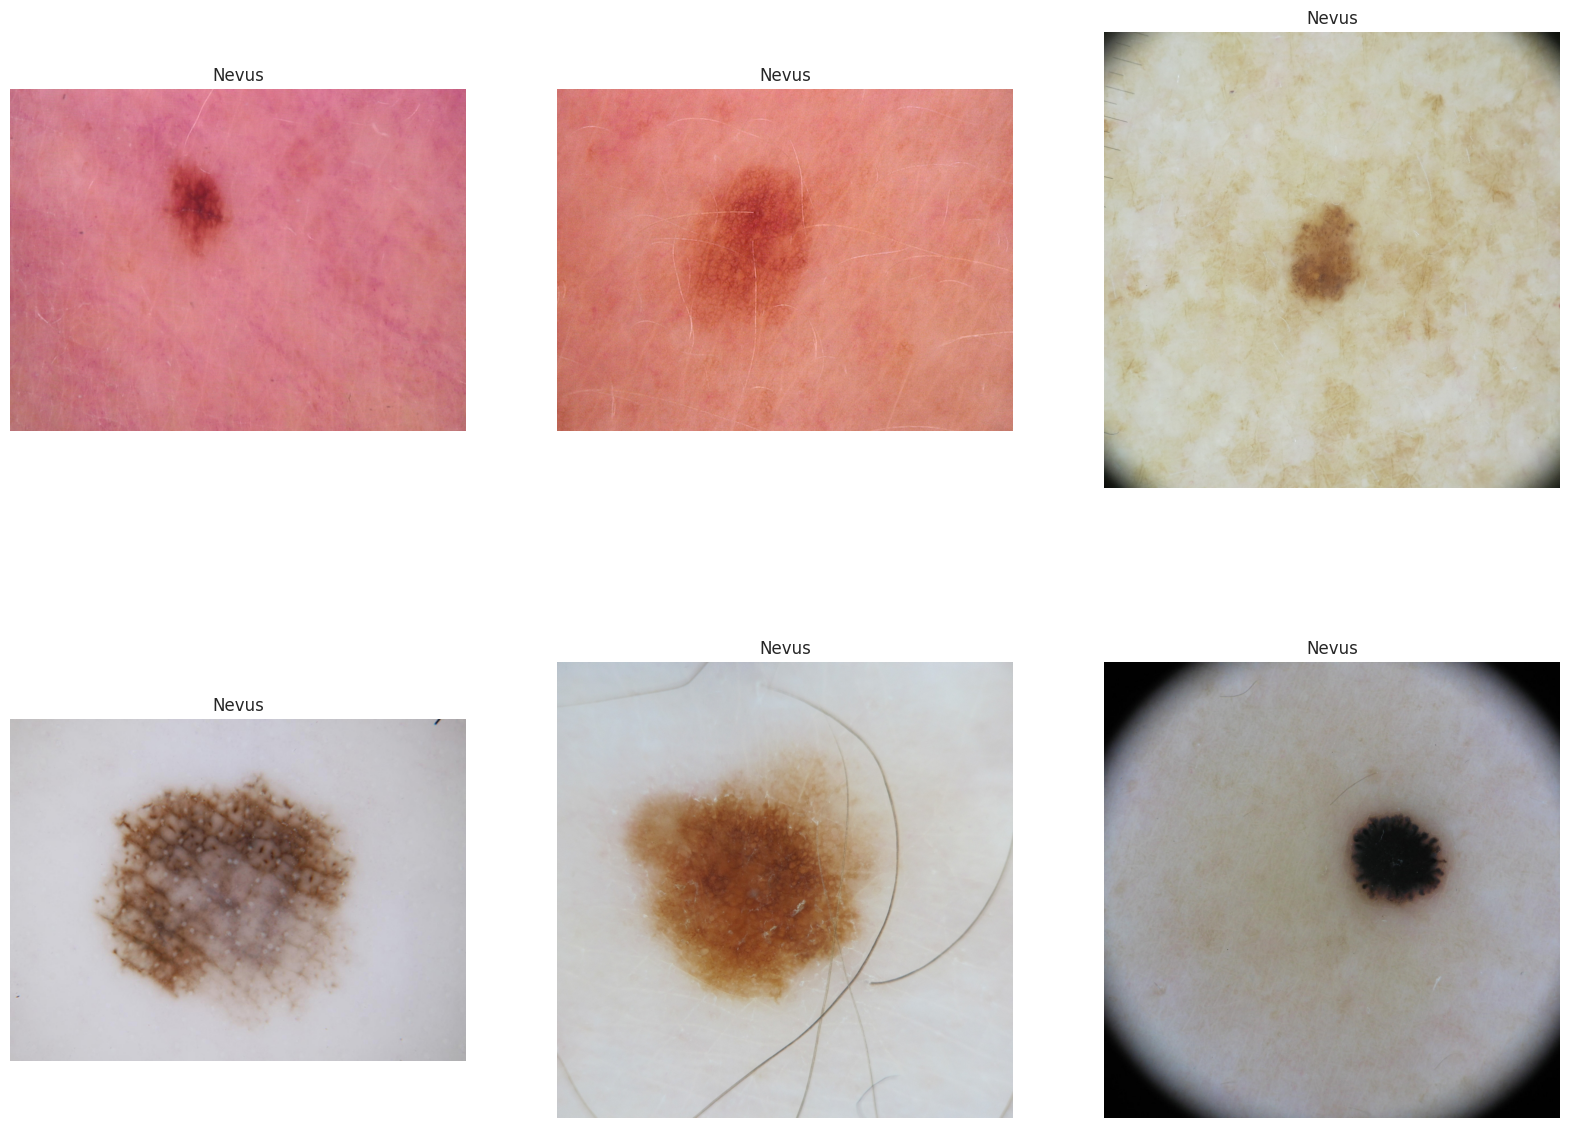

In [5]:
sns.set_style("white")

plt.figure(figsize = [20, 15])
for i, (image_path, ground_truth) in enumerate(zip(tr_df["tr_img_file"][:6], tr_df["tr_gtruth"][:6])):
    title = "Nevus" if ground_truth == 0 else "Others"     # Set the title based on ground truth
    image_data = cv.imread(image_path)                     # Read the image data using OpenCV
    plt.subplot(2, 3, i + 1)                               # Plot the image
    plt.imshow(cv.cvtColor(image_data, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.axis("off"); plt.title(title)

plt.show()

*- On Validation Dataset*

In [6]:
# Define directory path
val_dir_path = "/kaggle/input/binary-classification-nevus-benign/Challenge_1/val"
val_nevus = os.path.join(val_dir_path, "nevus")
val_others = os.path.join(val_dir_path, "others")

# Creating validation data lists and labels
val_image_names = []; val_image_files = []; val_gtruth_names = []; val_gtruth = []
for nevus_img in tqdm(os.listdir(val_nevus), desc = "Loading Nevus"):
    val_image_names.append(nevus_img)
    val_image_files.append(os.path.join(val_nevus, nevus_img))
    val_gtruth_names.append("nevus")
    val_gtruth.append(0)
        
for others_img in tqdm(os.listdir(val_others), desc = "Loading Others"):
    val_image_names.append(others_img)
    val_image_files.append(os.path.join(val_others, others_img))
    val_gtruth_names.append("others")
    val_gtruth.append(1)
    
# Create a dataframe
val_data = {"val_img_name": val_image_names, "val_img_file": val_image_files, "val_gtruth_name": val_gtruth_names, "val_gtruth": val_gtruth}; val_image_names.sort()
val_df = pd.DataFrame(val_data)
val_df.head()

Loading Others: 100%|██████████| 1865/1865 [00:00<00:00, 231246.55it/s]


,val_img_name,val_img_file,val_gtruth_name,val_gtruth
0,ack00521.jpg,/kaggle/input/binary-classification-nevus-beni...,nevus,0
1,ack00522.jpg,/kaggle/input/binary-classification-nevus-beni...,nevus,0
2,ack00523.jpg,/kaggle/input/binary-classification-nevus-beni...,nevus,0
3,ack00524.jpg,/kaggle/input/binary-classification-nevus-beni...,nevus,0
4,ack00525.jpg,/kaggle/input/binary-classification-nevus-beni...,nevus,0


# (B): DATA PREPROCESSING

**Data generation**
    
    Split the "tr_df" class-wise to maintain class distribution. Training = first 80%, Fake_Test = second 20%

In [7]:
# Create StratifiedShuffleSplit object for class-wise splitting
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

# Get the indices for splitting
train_indices, ftest_indices = next(sss.split(tr_df["tr_img_file"], tr_df["tr_gtruth_name"]))

# Create dataframes for training and fake_test
train_df_split = tr_df.iloc[train_indices]
ftest_df_split = tr_df.iloc[ftest_indices]

**Data augmentation**

In [8]:
# Data preprocessing (real-time augmentation) for 
# -----: (1) training
train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, horizontal_flip = True, vertical_flip = True)
# train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
# -----: (2) fake_test
ftest_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 32 # batch size
# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(dataframe = train_df_split, x_col = "tr_img_file", y_col = "tr_gtruth_name",
                                                    target_size = (224, 224), batch_size = batch_size, class_mode = "binary")      

# Flow validation images in batches using ftest_datagen generator
ftest_generator = ftest_datagen.flow_from_dataframe(dataframe = ftest_df_split, x_col = "tr_img_file", y_col = "tr_gtruth_name",
                                                    target_size = (224, 224), batch_size = batch_size, class_mode = "binary")

Found 12156 validated image filenames belonging to 2 classes.
Found 3039 validated image filenames belonging to 2 classes.


**Compute class weight for unbalanced dataset**

In [9]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = np.unique(train_df_split["tr_gtruth_name"])
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=train_df_split["tr_gtruth_name"])
class_weights_dict = dict(zip(range(len(class_labels)), class_weights))

**-----: Data Preprocessing (Augmentation) On Validation Data**

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255)

# Evaluate the model on the validation set
val_generator = val_datagen.flow_from_dataframe(dataframe = val_df, x_col = "val_img_file", y_col = "val_gtruth_name",
                                                target_size = (224, 224), batch_size = batch_size, class_mode = "binary", shuffle=False)

# (C): FEATURE EXTRACTION AND CLASSIFICATION

**Leveraging DL models for feature extraction and classification:**

    - Pre-trained model ()

# **- Pre-trained model (InceptionV3)**

    NB: Did not later use it!

# **- Pre-trained model (EfficientNet V2 B0)**

Reference: https://www.kaggle.com/code/matthewjansen/transfer-learning-skin-cancer-classification

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub

# Function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link, trainable=model_trainable, name=model_name)

# Get EfficientNet V2 B0 from TensorFlow Hub
efficientnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2'
model_name = 'efficientnet_v2_b0'
set_trainable=False # Set trainable to False for inference-only 

efficientnet_v2_b0 = get_tfhub_model(efficientnet_v2_url, model_name, model_trainable=set_trainable)

# Define the EfficientNet V2 B0 model
def efficientnet_v2_model():
    initializer = tf.keras.initializers.GlorotNormal()
    
    efficientnet_v2_sequential = Sequential([
        layers.Input(shape=(224, 224, 3), dtype=tf.float32, name='input_image'),
        efficientnet_v2_b0,
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ], name='efficientnet_v2_sequential_model')
    
    return efficientnet_v2_sequential

# Generate the EfficientNet V2 B0 model
model_efficientnet_v2 = efficientnet_v2_model()

# Display the model summary
model_efficientnet_v2.summary()

Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_v2_b0 (KerasL  (None, 1280)              5919312   
 ayer)                                                           
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6083409 (23.21 MB)
Trainable params: 164097 (641.00 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


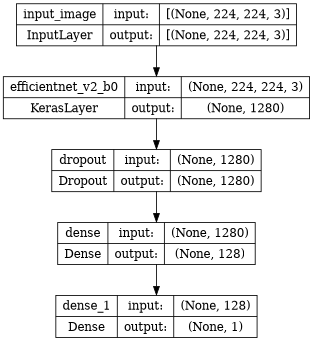

In [11]:
# Visualize the model
plot_model(model_efficientnet_v2, dpi=60, show_shapes=True)

In [12]:
# Compile the model
model_efficientnet_v2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [2]:
# Train the model
efficientnet_v2_history = model_efficientnet_v2.fit(train_generator, epochs=10, validation_data=ftest_generator, class_weight=class_weights_dict)

    Callbacks + Model Training (30 epochs)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_efficientnet_v2_E30.hdf5', save_best_only=True, monitor='val_accuracy', verbose=1)

callback_list = [model_chkpt, lr_reduce]

efficientnet_v2_history = model_efficientnet_v2.fit(train_generator, epochs=30, validation_data=ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

In [13]:
# # Save the model weights
# model_efficientnet_v2.save_weights('/kaggle/working/model_efficientnet_v2_weights.h5')
# print("Model has been saved.")

# Load the saved weights
model_efficientnet_v2.load_weights('/kaggle/input/binary-best-models/Binary_Best_Models/model_efficientnet_v2_weights.h5')

95/95 [==============================] - 29s 309ms/step - loss: 0.3587 - accuracy: 0.8355
Ftest Loss: 0.35873162746429443, Ftest Accuracy: 0.8354721665382385


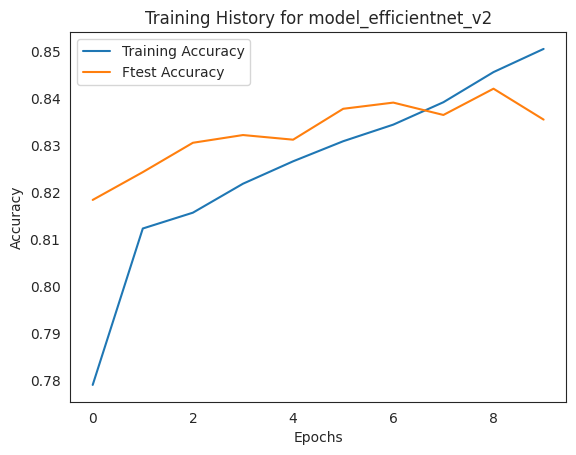

In [23]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_efficientnet_v2.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(efficientnet_v2_history.history['accuracy'], label='Training Accuracy')
plt.plot(efficientnet_v2_history.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_efficientnet_v2')
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Leveraging trained model for feature extraction and classification**

119/119 [==============================] - 87s 696ms/step - loss: 0.3664 - accuracy: 0.8406
Validation Loss: 0.3663662374019623, Validation Accuracy: 0.8406217098236084
119/119 [==============================] - 49s 404ms/step
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1931
           1       0.83      0.85      0.84      1865

    accuracy                           0.84      3796
   macro avg       0.84      0.84      0.84      3796
weighted avg       0.84      0.84      0.84      3796



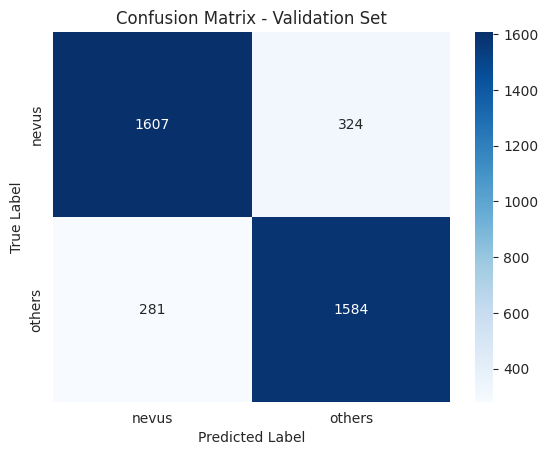

In [15]:
# Evaluate the model on the validation set
val_loss, val_acc = model_efficientnet_v2.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predictions on the validation set
val_predictions = model_efficientnet_v2.predict(val_generator)
val_pred_classes = (val_predictions > 0.5).astype(int)

# Display classification report
print("Classification Report on Validation Set:\n", classification_report(val_generator.classes, val_pred_classes))

# Display confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, val_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show() 

# **- Pre-trained model (Vision Transformer)**

Reference: https://www.kaggle.com/code/matthewjansen/transfer-learning-skin-cancer-classification

In [16]:
!pip install -q vit-keras

In [17]:
# Import necessary libraries for ViT
from vit_keras import vit

# Download the ViT model
vit_model = vit.vit_b16(image_size=224, activation='sigmoid', pretrained=True, include_top=False, pretrained_top=False, classes=2)

# Freeze model layers for inference-mode only
for layer in vit_model.layers:
    layer.trainable = False
    
def vit_b16_model():
    # Initialize model weights
    initializer = tf.keras.initializers.GlorotNormal()
    
    # Create a Sequential model
    vit_b16_sequential = Sequential([
        layers.Input(shape=(224, 224, 3), dtype=tf.float32, name='input_image'),
        vit_model,
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ], name='vit_b16_sequential_model')
    
    return vit_b16_sequential

# Generate the ViT model
model_vit_b16 = vit_b16_model()

# Display the summary of the ViT model
model_vit_b16.summary()

347502902/347502902 [==============================] - 2s 0us/step
Model: "vit_b16_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               98432     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 85897217 (327.67 MB)
Trainable params: 98561 (385.00 KB)
Non-trainable params: 85798656 (327.30 MB)
_________________________________________________________________


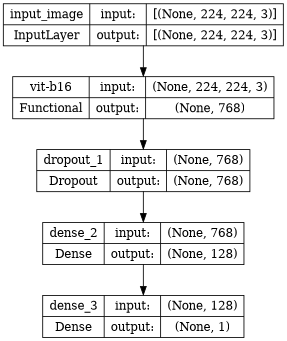

In [18]:
# Visualize the ViT model
plot_model(model_vit_b16, dpi=60, show_shapes=True)

In [19]:
# Compile the ViT model
model_vit_b16.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [30]:
# Assuming you have a function called train_model for training the model
vit_b16_history = model_vit_b16.fit(train_generator, epochs=10, validation_data=ftest_generator)

Epoch 1/10
380/380 [==============================] - 306s 770ms/step - loss: 0.4654 - accuracy: 0.7825 - val_loss: 0.4152 - val_accuracy: 0.8138
Epoch 2/10
380/380 [==============================] - 281s 737ms/step - loss: 0.4199 - accuracy: 0.8029 - val_loss: 0.4211 - val_accuracy: 0.8019
Epoch 3/10
380/380 [==============================] - 282s 741ms/step - loss: 0.4028 - accuracy: 0.8152 - val_loss: 0.3938 - val_accuracy: 0.8276
Epoch 4/10
380/380 [==============================] - 281s 737ms/step - loss: 0.3896 - accuracy: 0.8205 - val_loss: 0.3885 - val_accuracy: 0.8259
Epoch 5/10
380/380 [==============================] - 279s 734ms/step - loss: 0.3836 - accuracy: 0.8234 - val_loss: 0.4082 - val_accuracy: 0.8101
Epoch 6/10
380/380 [==============================] - 281s 738ms/step - loss: 0.3784 - accuracy: 0.8274 - val_loss: 0.3755 - val_accuracy: 0.8335
Epoch 7/10
380/380 [==============================] - 279s 733ms/step - loss: 0.3725 - accuracy: 0.8308 - val_loss: 0.3784 -

In [20]:
# # Save the model weights
# model_vit_b16.save_weights('/kaggle/working/model_vit_b16_weights.h5')
# print("Model has been saved.")

# Load the saved weights
model_vit_b16.load_weights('/kaggle/input/binary-best-models/Binary_Best_Models/model_vit_b16_weights.h5')

95/95 [==============================] - 41s 424ms/step - loss: 0.3647 - accuracy: 0.8401
Ftest Loss: 0.36470335721969604, Ftest Accuracy: 0.8400789499282837


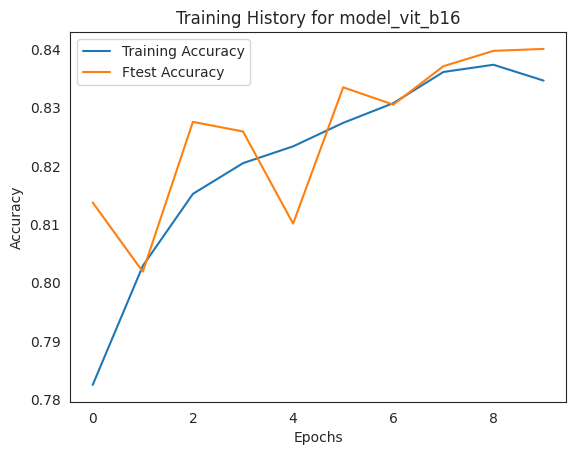

In [32]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_vit_b16.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(vit_b16_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_b16_history.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_vit_b16')
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Leveraging trained model for feature extraction and classification**

119/119 [==============================] - 54s 406ms/step - loss: 0.3703 - accuracy: 0.8274
Validation Loss: 0.3702748417854309, Validation Accuracy: 0.8274499177932739
119/119 [==============================] - 53s 413ms/step
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84      1931
           1       0.88      0.75      0.81      1865

    accuracy                           0.83      3796
   macro avg       0.83      0.83      0.83      3796
weighted avg       0.83      0.83      0.83      3796



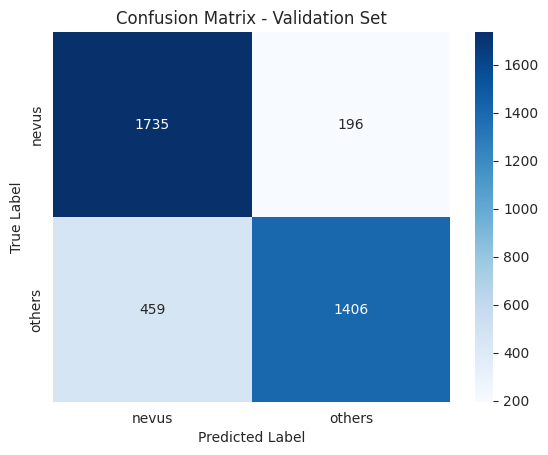

In [22]:
# Evaluate the model on the validation set
val_loss, val_acc = model_vit_b16.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predictions on the validation set
val_predictions = model_vit_b16.predict(val_generator)
val_pred_classes = (val_predictions > 0.5).astype(int)

# Display classification report
print("Classification Report on Validation Set:\n", classification_report(val_generator.classes, val_pred_classes))

# Display confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, val_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# **- Pre-trained model (EfficientNetB0)**

NB: This model was already implemented above!

# **- Pre-trained model (DenseNet121)**

In [23]:
# Load pre-trained DenseNet121 model with weights trained on ImageNet data
DN_model = DenseNet121(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in DN_model.layers:
    layer.trainable = False

model_dn = Sequential()
model_dn.add(DN_model)
model_dn.add(Flatten())
model_dn.add(Dense(128, activation = "relu"))
model_dn.add(Dropout(0.2))
model_dn.add(Dense(1, activation = "sigmoid"))

# Compile the model
model_dn.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0001), metrics = ["accuracy"])

# Display the model architecture
model_dn.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               6422656   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 13460289 (51.35 MB)
Trainable params: 6422785 (24.50 MB)
Non-trainable params: 7037504 (26.85 MB)
___________

    Callbacks

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_dn.hdf5', save_best_only=True, monitor='val_accuracy', verbose=1)

callback_list = [model_chkpt, lr_reduce]

In [12]:
# Train the model
history = model_dn.fit(train_generator, epochs = 30, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/30
380/380 [==============================] - ETA: 0s - loss: 0.7444 - accuracy: 0.7576
Epoch 1: val_accuracy improved from -inf to 0.80750, saving model to best_model_dn.hdf5
380/380 [==============================] - 429s 1s/step - loss: 0.7444 - accuracy: 0.7576 - val_loss: 0.4141 - val_accuracy: 0.8075 - lr: 0.0010
Epoch 2/30
380/380 [==============================] - ETA: 0s - loss: 0.4382 - accuracy: 0.7996
Epoch 2: val_accuracy did not improve from 0.80750
380/380 [==============================] - 261s 687ms/step - loss: 0.4382 - accuracy: 0.7996 - val_loss: 0.4533 - val_accuracy: 0.7887 - lr: 0.0010
Epoch 3/30
380/380 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.8059
Epoch 3: val_accuracy improved from 0.80750 to 0.81639, saving model to best_model_dn.hdf5
380/380 [==============================] - 263s 691ms/step - loss: 0.4248 - accuracy: 0.8059 - val_loss: 0.4043 - val_accuracy: 0.8164 - lr: 0.0010
Epoch 4/30
380/380 [=====================

In [25]:
# # Save the model_dn architecture as JSON
# model_dn_architecture_json = model_dn.to_json()
# with open('model_dn_architecture.json', 'w') as json_file:
#     json_file.write(model_dn_architecture_json)

# # Save the model weights
# model_dn.save_weights('model_dn_weights.h5')
# print("Model has been saved.")

# Load the saved weights
model_dn.load_weights('/kaggle/input/binary-best-models/Binary_Best_Models/best_model_dn.hdf5')

95/95 [==============================] - 30s 311ms/step - loss: 0.3760 - accuracy: 0.8371
Ftest Loss: 0.37604883313179016, Ftest Accuracy: 0.8371174931526184


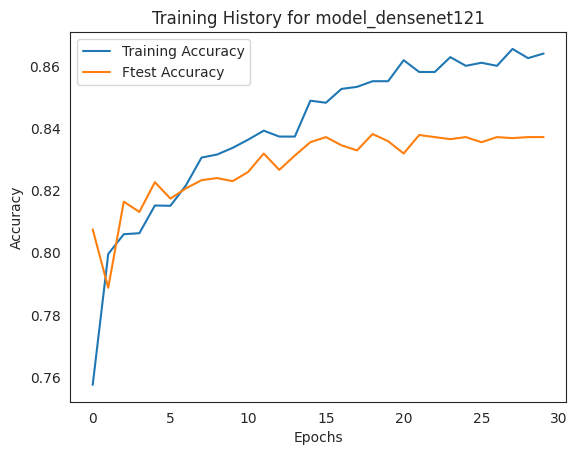

In [14]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_dn.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_densenet121')
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Leveraging trained model for feature extraction and classification**

119/119 [==============================] - 48s 356ms/step - loss: 0.3862 - accuracy: 0.8248
Validation Loss: 0.38623765110969543, Validation Accuracy: 0.824815571308136
119/119 [==============================] - 43s 344ms/step
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1931
           1       0.84      0.79      0.82      1865

    accuracy                           0.82      3796
   macro avg       0.83      0.82      0.82      3796
weighted avg       0.83      0.82      0.82      3796



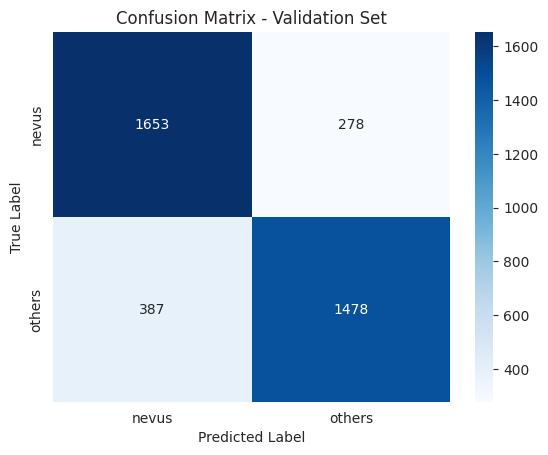

In [27]:
# Evaluate the model on the validation set
val_loss, val_acc = model_dn.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predictions on the validation set
val_predictions = model_dn.predict(val_generator)
val_pred_classes = (val_predictions > 0.5).astype(int)

# Display classification report
print("Classification Report on Validation Set:\n", classification_report(val_generator.classes, val_pred_classes))

# Display confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, val_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# **- Pre-trained model (ResNet50)**

Reference: https://github.com/Defcon27/Skin-Cancer-Classification-using-Transfer-Learning/blob/master/Skin%20Cancer%20Prediction%20ResNet50.ipynb

In [13]:
# Importing ResNet50 model from tf.keras.applications
from tensorflow.keras.applications.resnet50 import ResNet50

# Load pre-trained ResNet50 model with weights trained on ImageNet data
# resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
weight = "/kaggle/input/resnet50-weight/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
resnet_model = ResNet50(weights=weight, include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in resnet_model.layers:
    layer.trainable = True

# Build the custom model using ResNet50 as a feature extractor
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_resnet = Model(inputs=resnet_model.input, outputs=x)

# Compile the model
model_resnet.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"])

# Display the model architecture
model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

    Callbacks

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_resnet.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [21]:
# Train the model
history_resnet = model_resnet.fit(train_generator, epochs = 30, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/30
380/380 [==============================] - ETA: 0s - loss: 1.2817 - accuracy: 0.7444
Epoch 1: val_accuracy improved from -inf to 0.50839, saving model to best_model_resnet.hdf5
380/380 [==============================] - 317s 727ms/step - loss: 1.2817 - accuracy: 0.7444 - val_loss: 0.7441 - val_accuracy: 0.5084 - lr: 0.0010
Epoch 2/30
380/380 [==============================] - ETA: 0s - loss: 0.4923 - accuracy: 0.7874
Epoch 2: val_accuracy improved from 0.50839 to 0.64232, saving model to best_model_resnet.hdf5
380/380 [==============================] - 263s 691ms/step - loss: 0.4923 - accuracy: 0.7874 - val_loss: 0.6617 - val_accuracy: 0.6423 - lr: 0.0010
Epoch 3/30
380/380 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.7980
Epoch 3: val_accuracy improved from 0.64232 to 0.73906, saving model to best_model_resnet.hdf5
380/380 [==============================] - 263s 690ms/step - loss: 0.4581 - accuracy: 0.7980 - val_loss: 0.5479 - val_accuracy: 0.7391

    Callbacks & Model Training (50 epochs)

In [68]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_resnet_E50.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

# Train the model
history_resnet = model_resnet.fit(train_generator, epochs = 50, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/50
380/380 [==============================] - ETA: 0s - loss: 1.3162 - accuracy: 0.7118
Epoch 1: val_accuracy improved from -inf to 0.50839, saving model to best_model_resnet_E50.hdf5
380/380 [==============================] - 464s 1s/step - loss: 1.3162 - accuracy: 0.7118 - val_loss: 1.2457 - val_accuracy: 0.5084 - lr: 0.0010
Epoch 2/50
380/380 [==============================] - ETA: 0s - loss: 0.5075 - accuracy: 0.7710
Epoch 2: val_accuracy improved from 0.50839 to 0.54623, saving model to best_model_resnet_E50.hdf5
380/380 [==============================] - 270s 710ms/step - loss: 0.5075 - accuracy: 0.7710 - val_loss: 0.8621 - val_accuracy: 0.5462 - lr: 0.0010
Epoch 3/50
380/380 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.7848
Epoch 3: val_accuracy improved from 0.54623 to 0.68049, saving model to best_model_resnet_E50.hdf5
380/380 [==============================] - 269s 708ms/step - loss: 0.4696 - accuracy: 0.7848 - val_loss: 0.5644 - val_accurac

In [15]:
# # Save the model weights
# model_resnet.save_weights('model_resnet_weights.h5')
# print("Model has been saved.")

# Load the saved weights
model_resnet.load_weights('/kaggle/input/binary-best-models/Binary_Best_Models/best_model_resnet.hdf5')

# # Load the saved weights
# model_resnet.load_weights('/kaggle/working/best_model_resnet_E50.hdf5')

95/95 [==============================] - 31s 323ms/step - loss: 0.3474 - accuracy: 0.8690
Ftest Loss: 0.3473917543888092, Ftest Accuracy: 0.8690358400344849


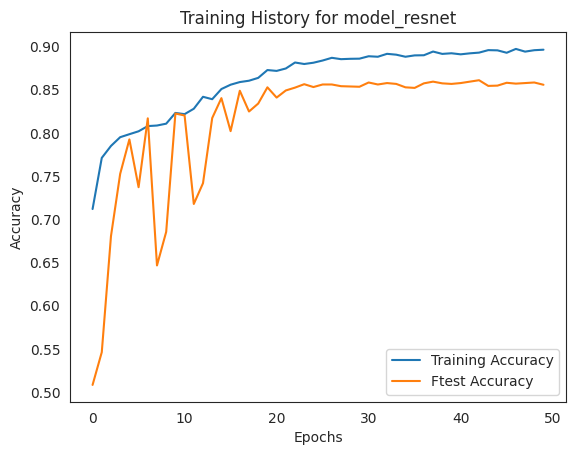

In [74]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_resnet.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_resnet')
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Leveraging trained model for feature extraction and classification**

119/119 [==============================] - 376s 3s/step - loss: 0.3544 - accuracy: 0.8622
Validation Loss: 0.3544430732727051, Validation Accuracy: 0.8622233867645264
119/119 [==============================] - 367s 3s/step
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      1931
           1       0.87      0.84      0.86      1865

    accuracy                           0.86      3796
   macro avg       0.86      0.86      0.86      3796
weighted avg       0.86      0.86      0.86      3796



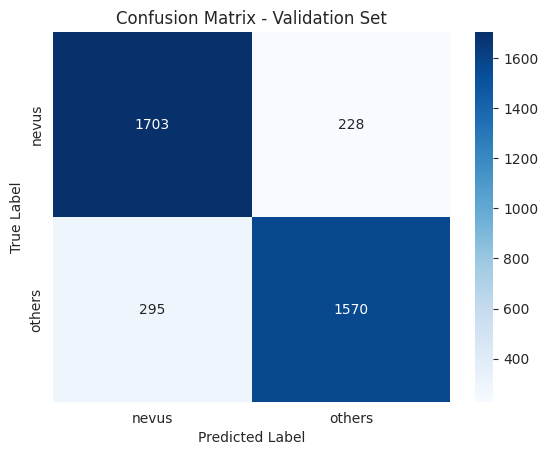

In [17]:
# Evaluate the model on the validation set
val_loss, val_acc = model_resnet.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predictions on the validation set
val_predictions = model_resnet.predict(val_generator)
val_pred_classes = (val_predictions > 0.5).astype(int)

# Display classification report
print("Classification Report on Validation Set:\n", classification_report(val_generator.classes, val_pred_classes))

# Display confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, val_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# **- Pre-trained model (InceptionResNetV2)**

Reference: https://github.com/Defcon27/Skin-Cancer-Classification-using-Transfer-Learning/blob/master/Skin%20Cancer%20Prediction%20ResNet50.ipynb

In [19]:
# Importing InceptionResNetV2 model from tf.keras.applications
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

# Load pre-trained InceptionResNetV2 model with weights trained on ImageNet data
# inceptionresnet_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
weight = "/kaggle/input/inceptionresnetv2-weight/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
inceptionresnet_model = InceptionResNetV2(weights=weight, include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in inceptionresnet_model.layers:
    layer.trainable = True

# Build the custom model using InceptionResNetV2 as a feature extractor
x = inceptionresnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_inceptionresnet = Model(inputs=inceptionresnet_model.input, outputs=x)

# Compile the model
model_inceptionresnet.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"])

# Display the model architecture
model_inceptionresnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_203 (Conv2D)         (None, 111, 111, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_203 (B  (None, 111, 111, 32)         96        ['conv2d_203[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_203 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_20

    Callbacks

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_inceptionresnet.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [12]:
# Train the model
history_inceptionresnet = model_inceptionresnet.fit(train_generator, epochs = 30, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/30
380/380 [==============================] - ETA: 0s - loss: 0.7976 - accuracy: 0.7787
Epoch 1: val_accuracy improved from -inf to 0.80487, saving model to best_model_inceptionresnet.hdf5
380/380 [==============================] - 547s 1s/step - loss: 0.7976 - accuracy: 0.7787 - val_loss: 0.4443 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 2/30
380/380 [==============================] - ETA: 0s - loss: 0.4445 - accuracy: 0.8041
Epoch 2: val_accuracy improved from 0.80487 to 0.81705, saving model to best_model_inceptionresnet.hdf5
380/380 [==============================] - 291s 765ms/step - loss: 0.4445 - accuracy: 0.8041 - val_loss: 0.4016 - val_accuracy: 0.8170 - lr: 0.0010
Epoch 3/30
380/380 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.8231
Epoch 3: val_accuracy did not improve from 0.81705
380/380 [==============================] - 290s 761ms/step - loss: 0.4233 - accuracy: 0.8231 - val_loss: 0.4705 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 4/30
380/

In [21]:
# # Save the model weights
# model_inceptionresnet.save_weights('model_inceptionresnet_weights.h5')
# print("Model has been saved.")

# Load the saved weights
model_inceptionresnet.load_weights('/kaggle/input/binary-best-models/Binary_Best_Models/best_model_inceptionresnet.hdf5')

95/95 [==============================] - 31s 322ms/step - loss: 0.4632 - accuracy: 0.8736
Ftest Loss: 0.46318721771240234, Ftest Accuracy: 0.87364262342453


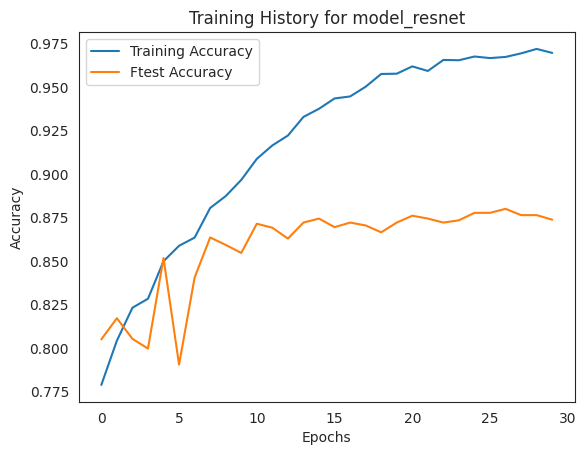

In [14]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_inceptionresnet.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history_inceptionresnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_inceptionresnet.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_resnet')
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Leveraging trained model for feature extraction and classification**

119/119 [==============================] - 473s 4s/step - loss: 0.4178 - accuracy: 0.8728
Validation Loss: 0.41778886318206787, Validation Accuracy: 0.8727607727050781
119/119 [==============================] - 473s 4s/step
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88      1931
           1       0.87      0.87      0.87      1865

    accuracy                           0.87      3796
   macro avg       0.87      0.87      0.87      3796
weighted avg       0.87      0.87      0.87      3796



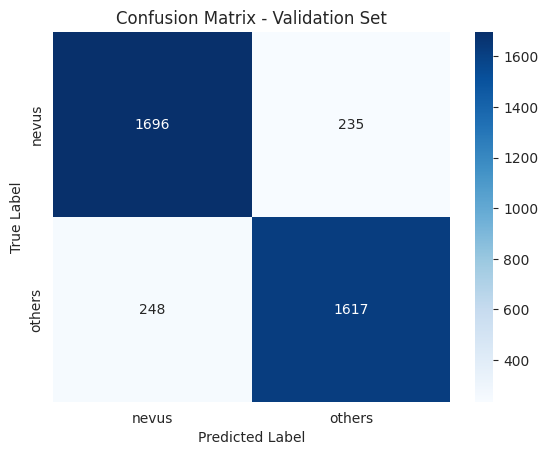

In [23]:
# Evaluate the model on the validation set
val_loss, val_acc = model_inceptionresnet.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predictions on the validation set
val_predictions = model_inceptionresnet.predict(val_generator)
val_pred_classes = (val_predictions > 0.5).astype(int)

# Display classification report
print("Classification Report on Validation Set:\n", classification_report(val_generator.classes, val_pred_classes))

# Display confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, val_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

In [24]:
# Predictions on the validation set
val_predictions = model_inceptionresnet.predict(val_generator, verbose=1)
val_predictions = (val_predictions > 0.5).astype(int)
val_true_labels = val_generator.classes # val_generator.classes contains the true labels

# Calculate evaluation metrics on the validation dataset
print("\n----- inceptionresnet EVALUATION METRICS -----\n")
accuracy_inceptionresnet = accuracy_score(val_true_labels, val_predictions); print(f"Accuracy: {accuracy_inceptionresnet}")
precision_inceptionresnet = precision_score(val_true_labels, val_predictions); print(f"Precision: {precision_inceptionresnet}")
recall_inceptionresnet = recall_score(val_true_labels, val_predictions); print(f"Recall: {recall_inceptionresnet}")
f1_inceptionresnet = f1_score(val_true_labels, val_predictions); print(f"F1-Score: {f1_inceptionresnet}")
roc_auc_inceptionresnet = roc_auc_score(val_true_labels, val_predictions); print(f"AUC Score: {roc_auc_inceptionresnet}")
balanced_accuracy_inceptionresnet = balanced_accuracy_score(val_true_labels, val_predictions); print(f"Balanced Accuracy: {balanced_accuracy_inceptionresnet}")

119/119 [==============================] - 473s 4s/step

----- inceptionresnet EVALUATION METRICS -----

Accuracy: 0.8727608008429927
Precision: 0.8731101511879049
Recall: 0.8670241286863271
F1-Score: 0.8700564971751411
AUC Score: 0.8726627634627906
Balanced Accuracy: 0.8726627634627906


# **- Pre-trained model (RegNet)**

NB: Was not implemented in the end!

In [ ]:
# Importing RegNet model from tf.keras.applications
from tensorflow.keras.applications.regnet import RegNetY032

# Load pre-trained RegNet model with weights trained on ImageNet data
regnet_model = RegNetY032(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in regnet_model.layers:
    layer.trainable = False

# Build the custom model using RegNet as a feature extractor
model_regnet = Sequential()
model_regnet.add(regnet_model)
model_regnet.add(GlobalAveragePooling2D())
model_regnet.add(Dense(128, activation="relu"))
model_regnet.add(Dense(1, activation="sigmoid"))

# Compile the model
model_regnet.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

# Display the model architecture
model_regnet.summary()

In [ ]:
# Train the model
history_regnet = model_regnet.fit(train_generator, epochs=30, validation_data=ftest_generator)

In [ ]:
# Save the trained model
model_regnet.save('model_regnet_weights.h5')

In [ ]:
# Evaluate the model on the fake_test set
ftest_loss_regnet, ftest_acc_regnet = model_regnet.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss_regnet}, Ftest Accuracy: {ftest_acc_regnet}')

# Plot training history for model_regnet
plt.plot(history_regnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_regnet.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_regnet')
plt.show()

**Leveraging regnet trained model on validation dataset**

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model_regnet.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predictions on the validation set
val_predictions = model_regnet.predict(val_generator)
val_pred_classes = (val_predictions > 0.5).astype(int)

# Display classification report
print("Classification Report on Validation Set:\n", classification_report(val_generator.classes, val_pred_classes))

# Display confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, val_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# **- Pre-trained model (SwinTransformer)**

NB: Was not later implemented!

# **- Pre-trained model (VGG16)**

In [39]:
from keras.applications.vgg16 import VGG16

# Load the VGG16 model without the top layer
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the vgg16_model layers
for layer in vgg16_model.layers:
    layer.trainable = False
    
# Add additional layers
model_vgg16 = Sequential()
model_vgg16.add(vgg16_model)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dense(1, activation='sigmoid'))

# Compile the model
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model_vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               6422784   
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 21137729 (80.63 MB)
Trainable params: 6423041 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


    Callbacks

In [40]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_vgg16.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [12]:
# Train the model
history_vgg16 = model_vgg16.fit(train_generator, epochs = 30, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/30
380/380 [==============================] - ETA: 0s - loss: 0.5639 - accuracy: 0.7355
Epoch 1: val_accuracy improved from -inf to 0.75913, saving model to best_model_vgg16.hdf5
380/380 [==============================] - 343s 883ms/step - loss: 0.5639 - accuracy: 0.7355 - val_loss: 0.4888 - val_accuracy: 0.7591 - lr: 0.0010
Epoch 2/30
380/380 [==============================] - ETA: 0s - loss: 0.4859 - accuracy: 0.7673
Epoch 2: val_accuracy improved from 0.75913 to 0.77920, saving model to best_model_vgg16.hdf5
380/380 [==============================] - 253s 665ms/step - loss: 0.4859 - accuracy: 0.7673 - val_loss: 0.4650 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 3/30
380/380 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.7857
Epoch 3: val_accuracy improved from 0.77920 to 0.78677, saving model to best_model_vgg16.hdf5
380/380 [==============================] - 255s 671ms/step - loss: 0.4634 - accuracy: 0.7857 - val_loss: 0.4535 - val_accuracy: 0.7868 - 

In [41]:
# # Save the model weights
# model_vgg16.save_weights('model_inceptionresnet_weights.h5')
# print("Model has been saved.")

# Load the saved weights
model_vgg16.load_weights('/kaggle/input/binary-best-models/Binary_Best_Models/best_model_vgg16.hdf5')

95/95 [==============================] - 28s 296ms/step - loss: 0.4132 - accuracy: 0.8128
Ftest Loss: 0.4131978452205658, Ftest Accuracy: 0.8127673864364624


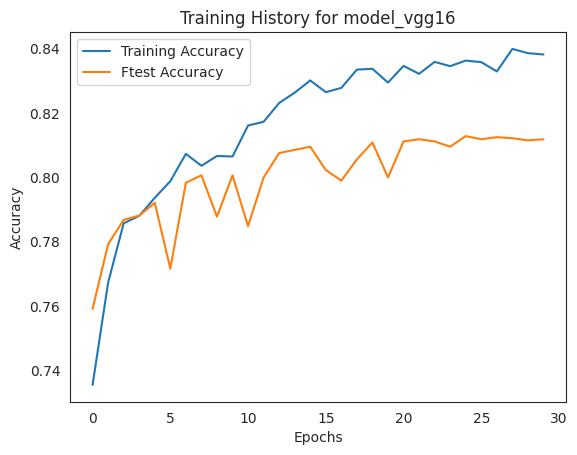

In [17]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_vgg16.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_vgg16')
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Leveraging trained model for feature extraction and classification**

119/119 [==============================] - 48s 363ms/step - loss: 0.4184 - accuracy: 0.8111
Validation Loss: 0.41843193769454956, Validation Accuracy: 0.8111169934272766
119/119 [==============================] - 40s 333ms/step
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1931
           1       0.83      0.78      0.80      1865

    accuracy                           0.81      3796
   macro avg       0.81      0.81      0.81      3796
weighted avg       0.81      0.81      0.81      3796



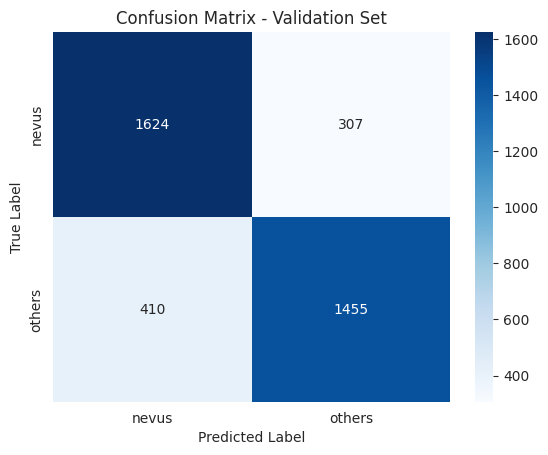

In [43]:
val_loss, val_acc = model_vgg16.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predictions on the validation set
val_predictions = model_vgg16.predict(val_generator)
val_pred_classes = (val_predictions > 0.5).astype(int)

# Display classification report
val_true_classes = val_generator.classes  # Access the true classes from the generator
print("Classification Report on Validation Set:\n", classification_report(val_true_classes, val_pred_classes))

# Display confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()


In [44]:
# Load the saved weights
# model_vgg16.load_weights('model_vgg16_weights.h5')

# Evaluate the model on the validation set
val_loss, val_acc = model_vgg16.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predictions on the validation set
val_predictions = model_vgg16.predict(val_generator, verbose=1)
val_predictions = (val_predictions > 0.5).astype(int)
val_true_labels = val_generator.classes # val_generator.classes contains the true labels

# Calculate evaluation metrics on the validation dataset
print("\n----- VGG16 EVALUATION METRICS -----\n")
accuracy_vgg16 = accuracy_score(val_true_labels, val_predictions); print(f"Accuracy: {accuracy_vgg16}")
precision_vgg16 = precision_score(val_true_labels, val_predictions); print(f"Precision: {precision_vgg16}")
recall_vgg16 = recall_score(val_true_labels, val_predictions); print(f"Recall: {recall_vgg16}")
f1_vgg16 = f1_score(val_true_labels, val_predictions); print(f"F1-Score: {f1_vgg16}")
roc_auc_vgg16 = roc_auc_score(val_true_labels, val_predictions); print(f"AUC Score: {roc_auc_vgg16}")
balanced_accuracy_vgg16 = balanced_accuracy_score(val_true_labels, val_predictions); print(f"Balanced Accuracy: {balanced_accuracy_vgg16}")

119/119 [==============================] - 41s 341ms/step - loss: 0.4184 - accuracy: 0.8111
Validation Loss: 0.41843193769454956, Validation Accuracy: 0.8111169934272766
119/119 [==============================] - 41s 348ms/step

----- VGG16 EVALUATION METRICS -----

Accuracy: 0.8111169652265543
Precision: 0.825766174801362
Recall: 0.7801608579088471
F1-Score: 0.8023159636062862
AUC Score: 0.8105879380170854
Balanced Accuracy: 0.8105879380170854


# **- ENSEMBLE OF RESNET50 + INCEPTIONRESNETV2**

In [ ]:
from tensorflow.keras.models import load_model

# Load pre-trained models
model_resnet = load_model('/kaggle/input/binary-best-models/Binary_Best_Models/best_model_resnet.hdf5')
model_inceptionresnet = load_model('/kaggle/input/binary-best-models/Binary_Best_Models/best_model_inceptionresnet.hdf5')

# Predictions on the validation set for both models
val_predictions_resnet = model_resnet.predict(val_generator)
val_predictions_inceptionresnet = model_inceptionresnet.predict(val_generator)

# Combine predictions (you can use averaging or another strategy)
ensemble_predictions = 0.5 * (val_predictions_resnet + val_predictions_inceptionresnet)
ensemble_pred_classes = (ensemble_predictions > 0.5).astype(int)

# Display classification report for the ensemble
print("Classification Report on Validation Set - Ensemble:\n", classification_report(val_generator.classes, ensemble_pred_classes))

# Display confusion matrix for the ensemble
conf_matrix_ensemble = confusion_matrix(val_generator.classes, ensemble_pred_classes)
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set - Ensemble')
plt.show()

# **- Pre-trained model (MobileNet)**

In [ ]:
import tensorflow

# Load pre-trained MobileNet model with weights trained on ImageNet data
from tensorflow.keras.applications.mobilenet import MobileNet
# Path to the manually downloaded weights file
weights_path = '/kaggle/input/mobilenet-weight/mobilenet_1_0_224_tf.h5'

# Load pre-trained MobileNet model with weights trained on ImageNet data
mobilenet_model = MobileNet(weights = weights_path, input_shape = (224, 224, 3)) # include_top = False

# Freeze the layers of the pre-trained model
for layer in mobilenet_model.layers[:-23]:
    layer.trainable = False

# Exclude the last 5 layers of the MobileNet model
x = mobilenet_model.layers[-6].output
x = tensorflow.keras.layers.Flatten()(x)
x = tensorflow.keras.layers.Dense(1024, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.25)(x)
x = tensorflow.keras.layers.Dense(1, activation='sigmoid')(x)
model_mobilenet = tensorflow.keras.models.Model(inputs=mobilenet_model.input, outputs=x)

# Compile the model
model_mobilenet.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.01), metrics = ["accuracy"])

# Display the model architecture
model_mobilenet.summary()

    Callbacks

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_mobilenet.hdf5', save_best_only=True, monitor='val_accuracy', verbose=1)

callback_list = [model_chkpt, lr_reduce]

In [ ]:
# Train the model
history_mobilenet = model_mobilenet.fit(train_generator, epochs = 20, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

In [ ]:
# Load the saved weights
model_mobilenet.load_weights('')

**Leveraging trained model for feature extraction and classification**

In [ ]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_mobilenet.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_mobilenet')
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

In [ ]:
val_loss, val_acc = model_mobilenet.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predictions on the validation set
val_predictions = model_mobilenet.predict(val_generator)
val_pred_classes = (val_predictions > 0.5).astype(int)

# Display classification report
val_true_classes = val_generator.classes  # Access the true classes from the generator
print("Classification Report on Validation Set:\n", classification_report(val_true_classes, val_pred_classes))

# Display confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# **- ENSEMBLE OF RESNET50 + INCEPTIONRESNETV2 + MOBILENET**

In [26]:
from tensorflow.keras.models import load_model

# Load pre-trained models
model_resnet = load_model('/kaggle/input/binary-best-models/Binary_Best_Models/best_model_resnet.hdf5')
model_inceptionresnet = load_model('/kaggle/input/binary-best-models/Binary_Best_Models/best_model_inceptionresnet.hdf5')
model_mobilenet = load_model("/kaggle/input/binary-best-models/Binary_Best_Models/best_model_mobilenet.hdf5")

# Predictions on the validation set for both models
val_predictions_resnet = model_resnet.predict(val_generator)
val_predictions_inceptionresnet = model_inceptionresnet.predict(val_generator)
val_predictions_mobilenet = model_mobilenet.predict(val_generator)

119/119 [==============================] - 111s 921ms/step


Classification Report on Validation Set - Ensemble:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89      1931
           1       0.89      0.87      0.88      1865

    accuracy                           0.88      3796
   macro avg       0.88      0.88      0.88      3796
weighted avg       0.88      0.88      0.88      3796



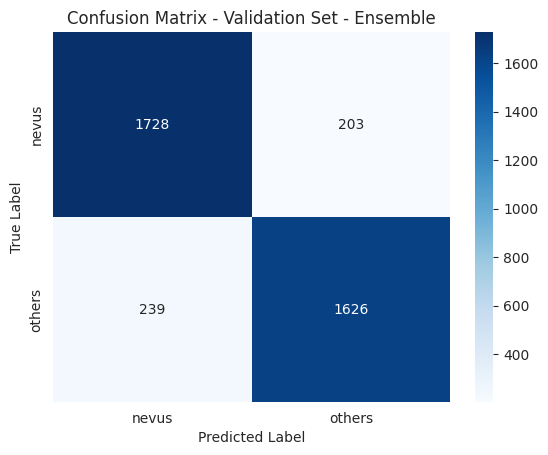

In [36]:
weight_resnet = 0.3; weight_inceptionresnet = 0.5; weight_mobilenet = 0.2 
ensemble_predictions = (weight_resnet * val_predictions_resnet) + (weight_inceptionresnet * val_predictions_inceptionresnet) + (weight_mobilenet * val_predictions_mobilenet)


# Combine predictions (you can use averaging or another strategy)
# ensemble_predictions = 0.5 * (val_predictions_resnet + val_predictions_inceptionresnet + val_predictions_mobilenet)
ensemble_pred_classes = (ensemble_predictions > 0.5).astype(int)

# Display classification report for the ensemble
print("Classification Report on Validation Set - Ensemble:\n", classification_report(val_generator.classes, ensemble_pred_classes))

# Display confusion matrix for the ensemble
conf_matrix_ensemble = confusion_matrix(val_generator.classes, ensemble_pred_classes)
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=['nevus', 'others'], yticklabels=['nevus', 'others'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set - Ensemble')
plt.show()

# **(D): LEVERAGING THE MODEL BUILT ON THE TEST DATASET**

**EXPLORATORY DATA ANALYSIS**

In [37]:
import tarfile
test_archive_path = "/kaggle/input/challenge-1-test/test.tgz" # path to the test archive
extracted_dir_path = "/kaggle/working/test_images"            # directory to extract images to

# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok = True)

# Extract the images from the archive
with tarfile.open(test_archive_path, "r:gz") as tar:
    tar.extractall(path = extracted_dir_path)

# List image names in the directory
test_img_name = os.listdir(os.path.join(extracted_dir_path, "testX"))

# Sort the image names in ascending order
test_img_name.sort()

# Create a list of dictionaries for each image
test_data = []
for img_name in test_img_name:
    test_img_file = os.path.join(extracted_dir_path, "testX", img_name)
    test_data.append({"test_img_name": img_name, "test_img_file": test_img_file})

# Create a DataFrame from the list of dictionaries
test_df = pd.DataFrame(test_data)
test_df.head()

,test_img_name,test_img_file
0,xxx00001.jpg,/kaggle/working/test_images/testX/xxx00001.jpg
1,xxx00002.jpg,/kaggle/working/test_images/testX/xxx00002.jpg
2,xxx00003.jpg,/kaggle/working/test_images/testX/xxx00003.jpg
3,xxx00004.jpg,/kaggle/working/test_images/testX/xxx00004.jpg
4,xxx00005.jpg,/kaggle/working/test_images/testX/xxx00005.jpg


**LEVERAGING THE TRAINED MODEL ON THE TEST DATASET**

**Data Preprocessing**

In [40]:
test_datagen = ImageDataGenerator(rescale = 1./255)

# Evaluate the model on the test set
test_generator = test_datagen.flow_from_dataframe(dataframe = test_df, x_col = "test_img_file",
                                                target_size = (224, 224), batch_size = batch_size, class_mode = None, shuffle=False)

Found 6340 validated image filenames.


**Leveraging trained model for feature extraction and classification**

In [13]:
from tensorflow.keras.models import load_model

# Load pre-trained models
model_resnet = load_model('/kaggle/input/binary-best-models/Binary_Best_Models/best_model_resnet.hdf5')
model_inceptionresnet = load_model('/kaggle/input/binary-best-models/Binary_Best_Models/best_model_inceptionresnet.hdf5')

# Predictions on the test set for both models
test_predictions_resnet = model_resnet.predict(test_generator)
test_predictions_inceptionresnet = model_inceptionresnet.predict(test_generator)

# Combine predictions (you can use averaging or another strategy)
ensemble_predictions = 0.5 * (test_predictions_resnet + test_predictions_inceptionresnet)
ensemble_pred_classes = (ensemble_predictions > 0.5).astype(int)

199/199 [==============================] - 62s 282ms/step


In [41]:
from tensorflow.keras.models import load_model

# Load pre-trained models
model_resnet = load_model('/kaggle/input/binary-best-models/Binary_Best_Models/best_model_resnet.hdf5')
model_inceptionresnet = load_model('/kaggle/input/binary-best-models/Binary_Best_Models/best_model_inceptionresnet.hdf5')
model_mobilenet = load_model("/kaggle/input/binary-best-models/Binary_Best_Models/best_model_mobilenet.hdf5")

# Predictions on the test set for both models
test_predictions_resnet = model_resnet.predict(test_generator)
test_predictions_inceptionresnet = model_inceptionresnet.predict(test_generator)
test_predictions_mobilenet = model_mobilenet.predict(test_generator)

# Combine predictions (you can use averaging or another strategy)
weight_resnet = 0.3; weight_inceptionresnet = 0.5; weight_mobilenet = 0.2 
ensemble_predictions = (weight_resnet * test_predictions_resnet) + (weight_inceptionresnet * test_predictions_inceptionresnet) + (weight_mobilenet * test_predictions_mobilenet)

# ensemble_predictions = 0.5 * (test_predictions_resnet + test_predictions_inceptionresnet)
ensemble_pred_classes = (ensemble_predictions > 0.5).astype(int)

199/199 [==============================] - 173s 864ms/step


In [42]:
# Flatten the predictions to ensure a 1-dimensional array
ensemble_pred_classes = ensemble_pred_classes.ravel()

# Create a DataFrame for the test results
test_results = pd.DataFrame({"image_name": test_df["test_img_name"], "image_label": ensemble_pred_classes})
test_results.head()

,image_name,image_label
0,xxx00001.jpg,0
1,xxx00002.jpg,0
2,xxx00003.jpg,1
3,xxx00004.jpg,1
4,xxx00005.jpg,1


In [43]:
# Save the test results to a CSV file
test_results.to_csv("/kaggle/working/binary_test_results_DL.csv", index=False)